In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [3]:
import time

def get_fitted_line_data(series):
    """
    Returns (slope, intercept, xaxis) of the line that best fits the series.
    See: http://glowingpython.blogspot.com/2012/03/linear-regression-with-numpy.html
    """
    xaxis = np.array([
        time.mktime(
            dt.replace(hour=0, minute=0, second=0, microsecond=0).timetuple()
        ) for dt in series.index.to_pydatetime()
    ])
    A = np.vstack([xaxis, np.ones(len(xaxis))]).T
    yaxis = series.values
    m, c = np.linalg.lstsq(A, yaxis)[0]
    return (m, c, xaxis)

def fit_line(series):
    """
    Returns a series that represents the line that best fits the data.
    """
    m, c, xaxis = get_fitted_line_data(series)
    return (m * xaxis + c)

def calculate_timeseries_slope(df, series_name, time_unit='days'):
    """
    df: Dataframe containing the time series.
    series_name: column name that contains the linear series.
    time_units: Calculate the slope as change in series units / change in time_units (default 'days').
    """
    ix = df.tail(2).index
    vals = ix.to_pydatetime()
    dt0 = vals[0]
    dt1 = vals[1]
    td = dt1 - dt0
    days = getattr(td, time_unit)
    line_series = df[series_name]
    p0 = line_series[-2]
    p1 = line_series[-1]
    delta = p1 - p0
    slope = float(delta) / float(days)
    return slope

In [4]:
import random

def line_func(x, m, c):
    return m*x + c

ix = pd.date_range('2015-10-01', '2015-11-01', freq='1D')
m = -100.5
data = [line_func(x, m, 7000) + random.randint(-5, 5)*abs(m) for x in range(len(ix))]
df = pd.DataFrame(data, index=ix, columns=['data'])
df.head()

,data
2015-10-01,6799.0
2015-10-02,6698.5
2015-10-03,7100.5
2015-10-04,7100.5
2015-10-05,7000.0


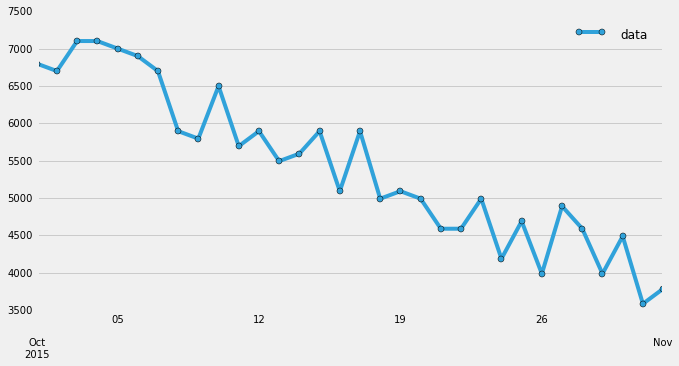

In [5]:
with plt.style.context(('fivethirtyeight')):
    df.plot(figsize=(10, 5), marker='o')

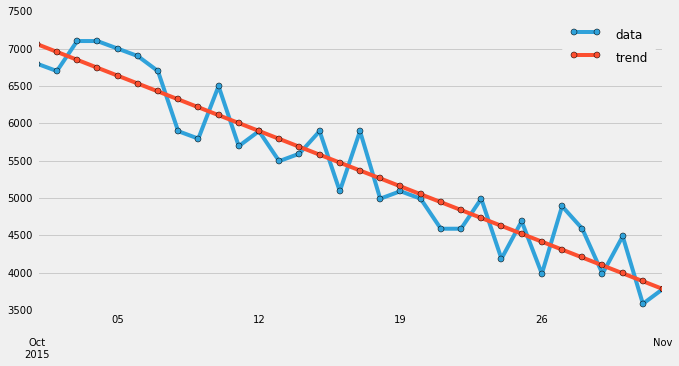

In [6]:
with plt.style.context(('fivethirtyeight')):
    trend = df.copy()
    trend["trend"] = fit_line(trend["data"])
    trend.plot(figsize=(10, 5), marker='o')

For points (x0, y0) and (x1, y1) on a line, the slope is equal to

$$ 
m = \frac{(y1 - y0)}{(x1 - x0)}
$$

Since we know the slope, and point (x0, y0), we can create a function to find any y given an x.


In [7]:
import datetime
import random

def dateindex2timestamps(series):
    return np.array([
        time.mktime(
            dt.replace(hour=0, minute=0, second=0, microsecond=0).timetuple()
        ) for dt in series.index.to_pydatetime()
    ])

def line_series_to_func(line_series):
    xseries = dateindex2timestamps(line_series)
    yseries = line_series.values
    choice_0 = random.randint(0, len(xseries) - 1)
    choice_1 = choice_0
    while choice_1 == choice_0:
        choice_1 = random.randint(0, len(xseries) - 1)
    y0 = yseries[choice_0]
    x0 = xseries[choice_0]
    y1 = yseries[choice_1]
    x1 = xseries[choice_1]
    m = (y1 - y0) / (x1 - x0)
    
    def _line_func(x):
        return m * (x - x0) + y0
    
    def _rline_func(y):
        return ((y - y0) / m) + x0
        
    return (_line_func, _rline_func)
  

datetime.datetime(2015, 12, 6, 15, 51, 0, 414648)

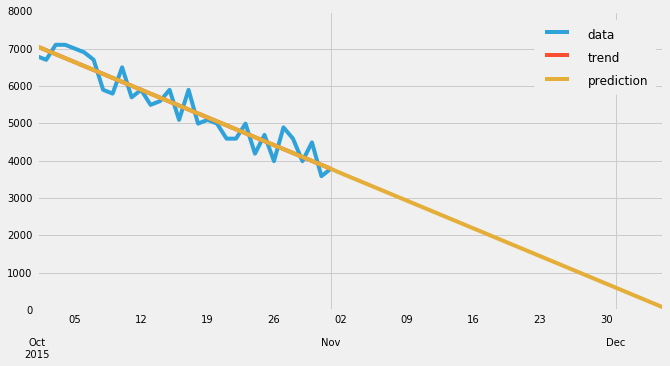

In [8]:
table = trend.copy()
fn, rfn = line_series_to_func(table["trend"])
x_intercept = datetime.datetime.fromtimestamp(rfn(0.0))
last_known_date = table.index.max()
ix = pd.date_range(table.index.min(), x_intercept, freq='1D')
table = table.reindex(ix)
table["prediction"] = [fn(ts) for ts in dateindex2timestamps(table["data"])]
with plt.style.context(('fivethirtyeight')):
    table.plot(figsize=(10, 5))
x_intercept